<a href="https://colab.research.google.com/github/AImSecure/Laboratory1/blob/main/lab/notebooks/Lab1_FFNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Laboratory 1 — Feed Forward Neural Networks

This notebook follows the lab brief in `resources/Lab1_FFNN.txt` and is organized into tasks:
- Task 1: Data preprocessing (cleaning, splitting, outliers, normalization)
- Task 2: Shallow NN (1 layer), train sizes {32, 64, 128}, metrics and analysis; then ReLU change
- Task 3: Impact of specific features (Destination Port), bias test and port removal
- Task 4: Loss function impact (weighted CrossEntropy)
- Task 5: Deep NN, batch size, optimizer comparisons
- Task 6: Overfitting and regularization (dropout, batchnorm, weight decay)

## Setup

In [2]:
# --- Check Python & pip versions ---
!python --version
!pip install --upgrade pip

Python 3.12.12
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 19.1 MB/s eta 0:00:00
  Attempting uninstall: pip
    Found existing installation: pip 24.1.2
    Uninstalling pip-24.1.2:
      Successfully uninstalled pip-24.1.2


In [3]:
# --- Install required libraries ---
!pip install torch
!pip install numpy pandas scikit-learn matplotlib seaborn
!pip install tqdm

In [4]:
# --- Import libraries ---
import os
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import json

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score
from sklearn.decomposition import PCA
from sklearn.impute import SimpleImputer

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, TensorDataset

from tqdm import tqdm

### Colab Pro

In [5]:
# --- Check GPU availability ---
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

/bin/bash: line 1: nvidia-smi: command not found


In [6]:
# --- Check RAM availability ---
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('Not using a high-RAM runtime')
else:
  print('You are using a high-RAM runtime!')

Your runtime has 13.6 gigabytes of available RAM

Not using a high-RAM runtime


### Paths setup


In [7]:
# --- Mount Google Drive (for Google Colab users) ---
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [8]:
# --- Define Paths ---
group = 'AImSecure'
laboratory = 'Laboratory1'

base_path = '/content/drive/MyDrive/'
project_path = base_path + f'Projects/{group}/{laboratory}/'
data_path = project_path + 'data/'
results_path = project_path + 'results/'

# --- Ensure directories exist ---
os.makedirs(project_path, exist_ok=True)
os.makedirs(data_path, exist_ok=True)
os.makedirs(results_path, exist_ok=True)

print(f"Project path: {project_path}")
print(f"Data path: {data_path}")
print(f"Results path: {results_path}")

Project path: /content/drive/MyDrive/Projects/AImSecure/Laboratory1/
Data path: /content/drive/MyDrive/Projects/AImSecure/Laboratory1/data/
Results path: /content/drive/MyDrive/Projects/AImSecure/Laboratory1/results/


In [9]:
# --- Set visual style ---
sns.set(style="whitegrid", palette="muted", font_scale=1.1)

def save_plot(fig: plt.Figure, filename: str, path: str = "./plots/", fmt: str = "png", dpi: int = 300) -> None:
    """
    Save a Matplotlib figure in a specific to a specified directory.

    Args:
        fig (plt.Figure): Matplotlib figure object to save.
        filename (str): Name of the file to save (e.g., 'plot.png').
        path (str, optional): Directory path to save the figure. Defaults to './plots/'.
        fmt (str, optional): File format for the saved figure. Defaults to 'png'.
        dpi (int, optional): Dots per inch for the saved figure. Defaults to 300.

    Returns:
        None
    """
    # Ensure the directory exists
    os.makedirs(path, exist_ok=True)
    save_path = os.path.join(path, f"{filename}.{fmt}")

    # Save the figure
    fig.savefig(save_path, bbox_inches='tight', pad_inches=0.1, dpi=dpi, format=fmt)
    # plt.close(fig) # Removed to display plots in notebook

    print(f"Saved plot: {save_path}")

## Task 1 — Data preprocessing
What we will do:
- Load CSV from `lab/data/dataset_lab_1.csv`
- Inspect basic info, class distribution, and feature ranges
- Remove NaN and duplicate rows; report counts before/after
- Split into train/val/test with stratify (60/20/20, fixed SEED)
- Inspect outliers on train/val (e.g., boxplots, z-scores) and choose normalization
- Fit scaler on train only; transform val/test; persist scaler if needed

In [10]:
# --- Load dataset and perform initial inspection ---

# Set random seed for reproducibility
np.random.seed(42)

# Create directory for plots
save_dir = results_path + 'images/' + 'task1_plots/'
os.makedirs(save_dir, exist_ok=True)

# Load Dataset
file_path = data_path + 'dataset_lab_1.csv'
df = pd.read_csv(file_path)

print("Shape (raw):", df.shape)
print("Columns:", list(df.columns))
print(df.head(3))

# Basic info
print("\nLabel distribution (raw):")
print(df['Label'].value_counts(dropna=False))

Shape (raw): (31507, 17)
Columns: ['Flow Duration', 'Flow IAT Mean', 'Fwd PSH Flags', 'Bwd Packet Length Mean', 'Bwd Packet Length Max', 'Flow Bytes/s', 'Down/Up Ratio', 'SYN Flag Count', 'Fwd Packet Length Mean', 'Fwd IAT Std', 'Packet Length Mean', 'Fwd Packet Length Max', 'Subflow Fwd Packets', 'Flow Packets/s', 'Total Fwd Packets', 'Destination Port', 'Label']
   Flow Duration  Flow IAT Mean  Fwd PSH Flags  Bwd Packet Length Mean  \
0         303376        30337.6              0                   749.4   
1            117          117.0              0                     0.0   
2            142          142.0              0                     0.0   

   Bwd Packet Length Max  Flow Bytes/s  Down/Up Ratio  SYN Flag Count  \
0                   1448     12743.263              0               0   
1                      0         0.000              1               0   
2                      0     84507.040              0               0   

   Fwd Packet Length Mean  Fwd IAT Std  Pac

In [11]:
def plot_class_distribution(
    df,
    label_col='Label',
    save_path='./plots/',
    fig_size=(8, 5),
    color='Set2'
):
    """
    Plot the number of samples for each class.

    Args:
        df (pd.DataFrame): The input DataFrame.
        label_col (str): The name of the label column. Defaults to 'Label'.
        save_path (str): The directory to save the plot. Defaults to './plots/'.
        fig_size (tuple): Size of the figure. Defaults to (8, 5).
        color (str): Seaborn color.
    """
    os.makedirs(save_path, exist_ok=True)

    # Create a figure and axes for the plot
    fig, ax = plt.subplots(figsize=fig_size)

    # Create a countplot showing the distribution of classes
    sns.countplot(x=label_col, data=df, order=df[label_col].value_counts().index, ax=ax, color='skyblue')

    # Set the title and labels for the plot
    ax.set_title("Class Distribution")
    ax.set_xlabel("Traffic Type")
    ax.set_ylabel("Count")

    # Rotate x-axis labels for better readability
    plt.xticks(rotation=30)

    # Annotate bars with counts
    for p in ax.patches:
        height = p.get_height()
        ax.annotate(f'{height}', (p.get_x() + p.get_width() / 2., height),
                    ha='center', va='bottom', fontsize=10)

    # Save the plot to the specified path
    save_plot(fig, "class_distribution", save_path)

Saved plot: /content/drive/MyDrive/Projects/AImSecure/Laboratory1/results/images/task1_plots/class_distribution.png


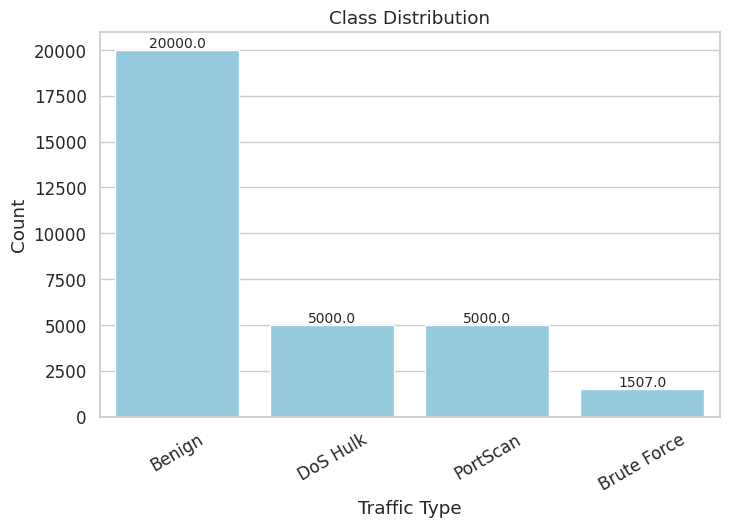

In [12]:
# --- Visualize raw data characteristics and distributions ---

# Plot class distribution to understand data balance
plot_class_distribution(df, save_path=save_dir)

# TODO: check for other useful plots

### Removing NaN and duplicates

In [13]:
# --- Remove NaN and duplicates ---

raw_n = len(df)
df = df.dropna()
df = df.drop_duplicates()
clean_n = len(df)

print(f"Removed {raw_n-clean_n} rows (NaN+dupes). New shape: {df.shape}")

Removed 2114 rows (NaN+dupes). New shape: (29393, 17)


In [14]:
print("\nLabel distribution (after NaN and duplicates removal):")
print(df['Label'].value_counts())


Label distribution (after NaN and duplicates removal):
Label
Benign         19248
PortScan        4850
DoS Hulk        3868
Brute Force     1427
Name: count, dtype: int64


### Split data

In [15]:
# --- Split data ---

# Split features/target
label_col = 'Label'
feature_cols = [c for c in df.columns if c != label_col]
X = df[feature_cols]
y = df[label_col]

# We use a stratified approach due to the class imbalance

# Train/val/test split 60/20/20 with stratify
X_train, X_tmp, y_train, y_tmp = train_test_split(
    X, y, test_size=0.4, stratify=y, random_state=42
)
X_val, X_test, y_val, y_test = train_test_split(
    X_tmp, y_tmp, test_size=0.5, stratify=y_tmp, random_state=42
)
print("Splits:", X_train.shape, X_val.shape, X_test.shape)
print("Train label counts:\n", y_train.value_counts())
print("Val label counts:\n", y_val.value_counts())
print("Test label counts:\n", y_test.value_counts())

Splits: (17635, 16) (5879, 16) (5879, 16)
Train label counts:
 Label
Benign         11548
PortScan        2910
DoS Hulk        2321
Brute Force      856
Name: count, dtype: int64
Val label counts:
 Label
Benign         3850
PortScan        970
DoS Hulk        774
Brute Force     285
Name: count, dtype: int64
Test label counts:
 Label
Benign         3850
PortScan        970
DoS Hulk        773
Brute Force     286
Name: count, dtype: int64


### Normalize data and handle outliers

In [16]:
def plot_boxplots_before_after(X_before, X_after, feature_names=None, save_path='./plots/'):
    """
    Compare feature distributions before and after normalization using boxplots.
    """
    # Use generic feature names if none are provided
    if feature_names is None:
        feature_names = [f'Feature_{i}' for i in range(X_before.shape[1])]

    # Create DataFrames from the input arrays for easier plotting
    df_before = pd.DataFrame(X_before, columns=feature_names)
    df_after = pd.DataFrame(X_after, columns=feature_names)

    # Iterate through each feature and create a comparison boxplot
    for col in feature_names:
        fig, axes = plt.subplots(1, 2, figsize=(10, 4))

        # Boxplot for the data before normalization
        sns.boxplot(y=df_before[col], ax=axes[0], color='lightgray')

        # Boxplot for the data after normalization
        sns.boxplot(y=df_after[col], ax=axes[1], color='lightblue')

        # Set titles for the subplots
        axes[0].set_title(f"{col} (Before)")
        axes[1].set_title(f"{col} (After)")

        # Set a main title for the figure
        plt.suptitle(f"Boxplot Comparison — {col}")

        # Replace '/' with '_' in filename to avoid path issues
        filename = f"boxplot_norm_comparison_{col.replace('/', '_')}"

        # Save the plot
        save_plot(fig, filename, save_path)

In [26]:
# --- Apply normalization with outlier handling ---

# TODO: check and update this block

# Outlier analysis: count features with z-score > 3 on training set
num_cols = X_train.select_dtypes(include=[np.number]).columns.tolist()
zs = ((X_train[num_cols] - X_train[num_cols].mean())/X_train[num_cols].std(ddof=0)).abs()
outlier_counts = (zs > 3).sum().sort_values(ascending=False)
print("\nOutliers (>3 std) per feature on train:\n", outlier_counts.head(10))

# Standardize features using StandardScaler fitted on training data only
scaler = StandardScaler()
X_train_s = scaler.fit_transform(X_train[num_cols]) # Apply to dataframe directly after dropping NaNs
X_val_s = scaler.transform(X_val[num_cols])
X_test_s = scaler.transform(X_test[num_cols])

# --- Save preprocessing metadata for reproducibility ---

scaler_meta = {
    "type":"StandardScaler",
    "fit_on":"train",
    "num_features": num_cols,
    "nan_handling": "dropped_rows" # Updated metadata
}

# Create metrics_dir if it doesn't exist
metrics_dir = results_path + 'metrics/'
os.makedirs(metrics_dir, exist_ok=True)

with open(os.path.join(metrics_dir, "scaler_meta.json"), "w") as f:
    json.dump(scaler_meta, f, indent=2)

print("Normalization complete. Shapes:", X_train_s.shape, X_val_s.shape, X_test_s.shape)


Outliers (>3 std) per feature on train:
 Fwd PSH Flags             709
SYN Flag Count            709
Fwd IAT Std               570
Flow Packets/s            531
Bwd Packet Length Max     523
Bwd Packet Length Mean    340
Packet Length Mean        274
Destination Port          232
Fwd Packet Length Max     204
Flow IAT Mean             196
dtype: int64
Normalization complete. Shapes: (17633, 16) (5876, 16) (5877, 16)


Saved plot: /content/drive/MyDrive/Projects/AImSecure/Laboratory1/results/images/task1_plots/boxplot_norm_comparison_Flow Duration.png
Saved plot: /content/drive/MyDrive/Projects/AImSecure/Laboratory1/results/images/task1_plots/boxplot_norm_comparison_Flow IAT Mean.png
Saved plot: /content/drive/MyDrive/Projects/AImSecure/Laboratory1/results/images/task1_plots/boxplot_norm_comparison_Flow Bytes_s.png
Saved plot: /content/drive/MyDrive/Projects/AImSecure/Laboratory1/results/images/task1_plots/boxplot_norm_comparison_Flow Packets_s.png
Saved plot: /content/drive/MyDrive/Projects/AImSecure/Laboratory1/results/images/task1_plots/boxplot_norm_comparison_Bwd Packet Length Mean.png
Saved plot: /content/drive/MyDrive/Projects/AImSecure/Laboratory1/results/images/task1_plots/boxplot_norm_comparison_Bwd Packet Length Max.png
Saved plot: /content/drive/MyDrive/Projects/AImSecure/Laboratory1/results/images/task1_plots/boxplot_norm_comparison_Fwd Packet Length Mean.png
Saved plot: /content/drive/My

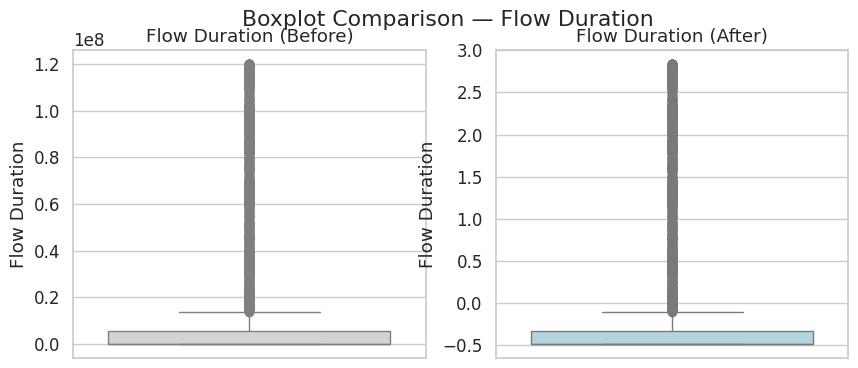

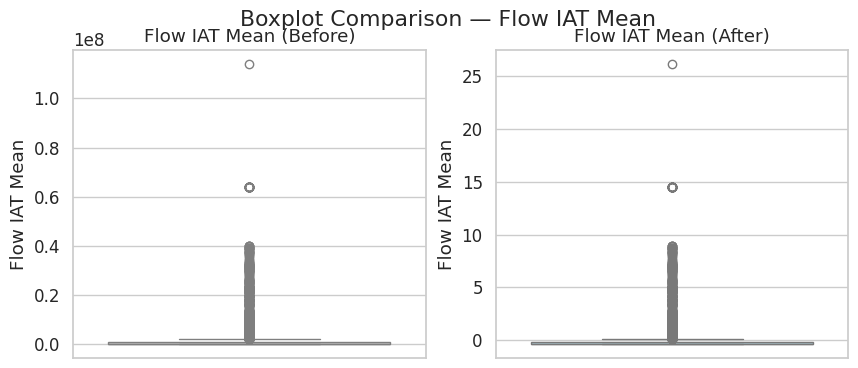

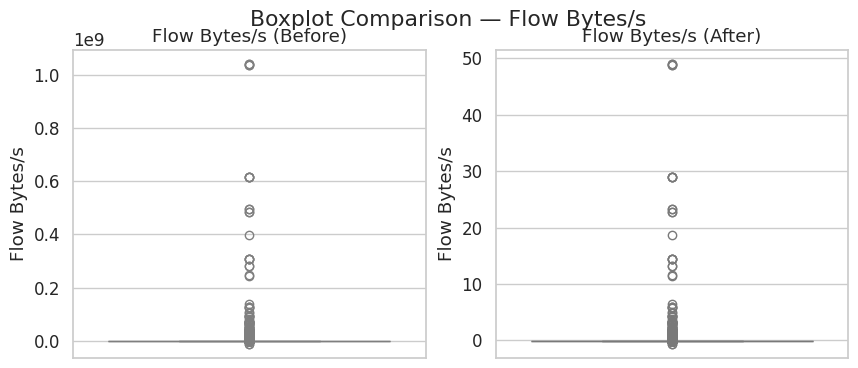

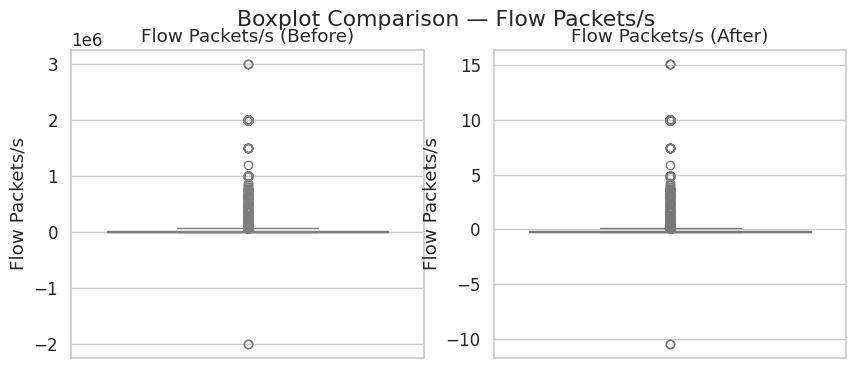

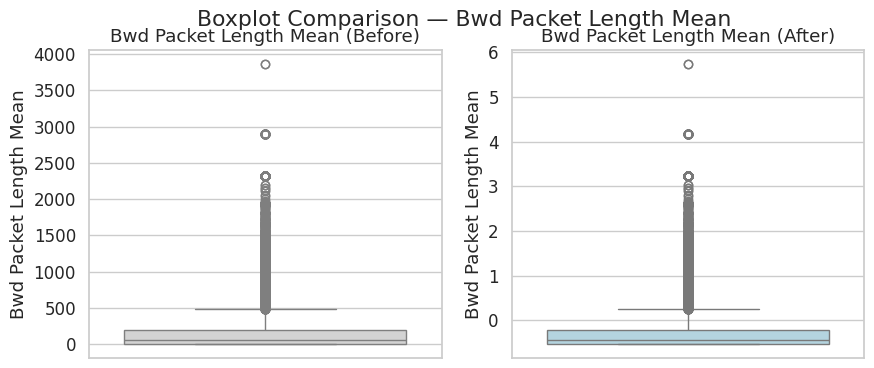

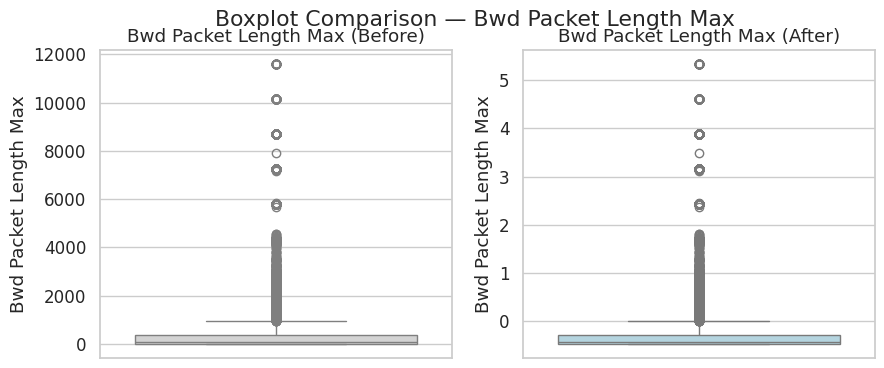

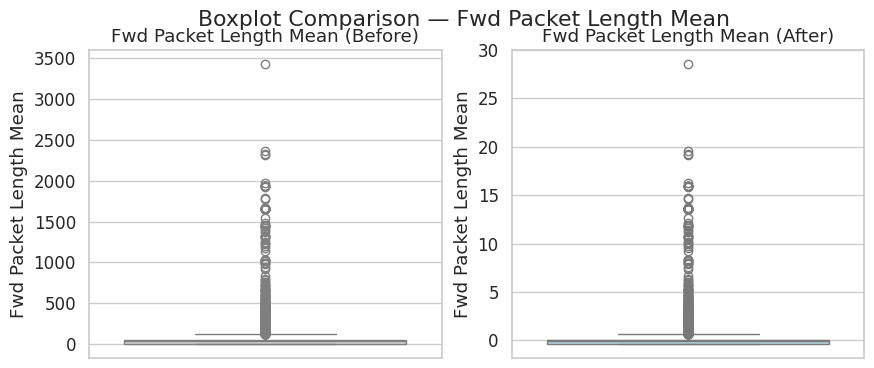

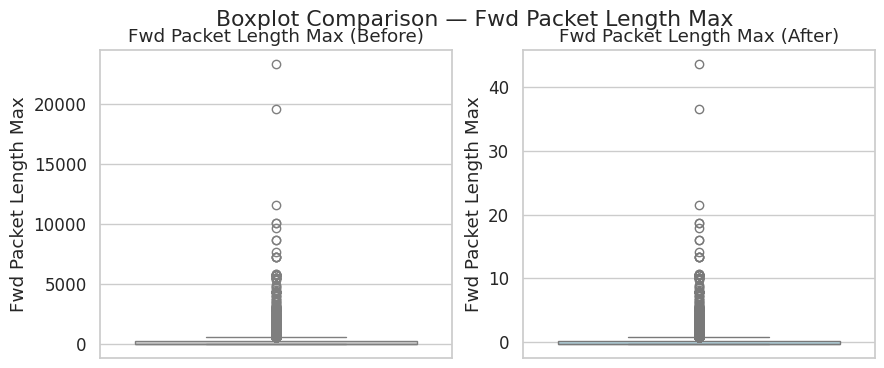

In [37]:
# --- Generate visualization plots for outlier analysis and dimensionality reduction ---

# TODO: remove functions that are not needed:
#plot_boxplots
#plot_boxplots_by_class
#plot_histograms_before_after


# Create boxplots for top numeric features

# Generate boxplots for the top features after standardization
top_features_for_plotting = [
    'Flow Duration',
    'Flow IAT Mean',
    'Flow Bytes/s',
    'Flow Packets/s',
    'Bwd Packet Length Mean',
    'Bwd Packet Length Max',
    'Fwd Packet Length Mean',
    'Fwd Packet Length Max'
]

# Ensure the plot_boxplots_before_after function is defined (it's in cell GsY0Xe28wZjM)
plot_boxplots_before_after(X_train[top_features_for_plotting], X_train_s[:, [numeric_cols.index(f) for f in top_features_for_plotting]], feature_names=top_features_for_plotting, save_path=save_dir)

In [ ]:
# --- Compare feature distributions before and after normalization ---

# TODO: check and update this block
# TODO: remove functions that are not needed

# Generate comparison plots showing normalization effect
#plot_boxplots_before_after(X_train, X_train_s, feature_names=numeric_features, save_path=save_dir) % FIXME: check also the function
#plot_histograms_before_after(X_train, X_train_s, feature_names=numeric_features, save_path=save_dir) % FIXME: check also the function

## PyTorch datasets and loaders
We convert standardized NumPy arrays to tensors and build dataloaders with a configurable batch size.

In [ ]:
# Label encoding
classes = sorted(pd.unique(y))
class_to_idx = {c:i for i,c in enumerate(classes)}
y_train_i = y_train.map(class_to_idx).to_numpy()
y_val_i = y_val.map(class_to_idx).to_numpy()
y_test_i = y_test.map(class_to_idx).to_numpy()

# Tensors
X_train_t = torch.tensor(X_train_s, dtype=torch.float32)
X_val_t   = torch.tensor(X_val_s,   dtype=torch.float32)
X_test_t  = torch.tensor(X_test_s,  dtype=torch.float32)
y_train_t = torch.tensor(y_train_i, dtype=torch.long)
y_val_t   = torch.tensor(y_val_i,   dtype=torch.long)
y_test_t  = torch.tensor(y_test_i,  dtype=torch.long)

INPUT_DIM = X_train_t.shape[1]
NUM_CLASSES = len(classes)
print("Input dim:", INPUT_DIM, "Classes:", NUM_CLASSES, classes)

# Dataloaders
BATCH_SIZE = 64
train_ds = TensorDataset(X_train_t, y_train_t)
val_ds   = TensorDataset(X_val_t, y_val_t)
test_ds  = TensorDataset(X_test_t, y_test_t)

train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True)
val_loader   = DataLoader(val_ds,   batch_size=BATCH_SIZE)
test_loader  = DataLoader(test_ds,  batch_size=BATCH_SIZE)

## Training utilities
Helper functions: training loop with early stopping, evaluation, and plotting loss curves.

In [ ]:
def train_one_epoch(model, loader, criterion, optimizer):
    model.train()
    total_loss = 0.0
    for xb, yb in loader:
        xb, yb = xb.to(device), yb.to(device)
        optimizer.zero_grad()
        logits = model(xb)
        loss = criterion(logits, yb)
        loss.backward()
        optimizer.step()
        total_loss += loss.item() * xb.size(0)
    return total_loss / len(loader.dataset)

@torch.no_grad()
def evaluate(model, loader, criterion=None):
    model.eval()
    total_loss = 0.0
    all_preds, all_targets = [], []
    for xb, yb in loader:
        xb, yb = xb.to(device), yb.to(device)
        logits = model(xb)
        if criterion is not None:
            total_loss += criterion(logits, yb).item() * xb.size(0)
        preds = torch.argmax(logits, dim=1)
        all_preds.append(preds.cpu().numpy())
        all_targets.append(yb.cpu().numpy())
    all_preds = np.concatenate(all_preds)
    all_targets = np.concatenate(all_targets)
    avg_loss = (total_loss / len(loader.dataset)) if criterion is not None else None
    return avg_loss, all_preds, all_targets

class EarlyStopper:
    def __init__(self, patience=10, mode='min'):
        self.patience = patience
        self.mode = mode
        self.best = None
        self.count = 0
    def step(self, metric):
        if self.best is None:
            self.best = metric
            return False
        improve = metric < self.best if self.mode == 'min' else metric > self.best
        if improve:
            self.best = metric
            self.count = 0
            return False
        else:
            self.count += 1
            return self.count >= self.patience

def plot_losses(train_losses, val_losses, title, save_path=None):
    fig, ax = plt.subplots(figsize=(6,4))
    ax.plot(train_losses, label='train')
    ax.plot(val_losses, label='val')
    ax.set_xlabel('Epoch')
    ax.set_ylabel('Loss')
    ax.set_title(title)
    ax.legend()
    plt.tight_layout()
    if save_path:
        save_plot_to_drive(fig, Path(save_path).name, Path(save_path).parent)
    plt.show()

## Task 2 — Shallow Neural Network (1 layer)
We will:
- Define a single-hidden-layer FFNN with hidden sizes h in {32, 64, 128}
- Use Linear activation as requested (i.e., no nonlinearity) for the first run
- Train with AdamW, lr=5e-4, batch=64, CE loss, up to 100 epochs with early stopping
- Plot train/val losses, select best by lowest val loss, report validation classification
- Evaluate best on test and compare to validation
- Then change activation to ReLU for the best width and retrain; discuss change

### ReLU variant for the best width
Train the same architecture but with ReLU activation, then compare validation report to the linear version. Do NOT test-compare unless justified (overfitting risk).

In [ ]:
# Train ReLU variant for the best width
best_h = best['h']
relu_tag = f"shallow_relu_h{best_h}"
model_relu = ShallowFFNN(INPUT_DIM, best_h, NUM_CLASSES, activation='relu')
model_relu, tr_r, va_r = train_model(model_relu, train_loader, val_loader, epochs=100, lr=5e-4, patience=10, tag=relu_tag)
va_loss_r, va_preds_r, va_tgts_r = evaluate(model_relu, val_loader, nn.CrossEntropyLoss())
print("Validation report (ReLU, best width)")
print(classification_report(va_tgts_r, va_preds_r, target_names=classes))
print("Note: Comparing on test at this stage may be misleading; validate design choices first.")

## Task 3 — Impact of specific features (Destination Port)
Steps:
1) Modify only the test split: for rows with Label==Brute Force and Destination Port==80, change to 8080. Re-run inference with the best model and compare test metrics to validation baseline.
2) Remove the Destination Port feature entirely from the original dataset; redo preprocessing (cleaning, split, scaling); report PortScan counts before/after duplicates removal; discuss class balance.
Note: Keep a copy of the original splits to ensure fair comparisons.

In [ ]:
# 3.1: Modify Destination Port for Brute Force in Test and re-evaluate
if 'Destination Port' in feature_cols:
    # Build a modifiable DataFrame for test
    test_df = X_test.copy()
    test_df['Label'] = y_test.values
    before_counts = (test_df[(test_df['Label']=='Brute Force') & (test_df['Destination Port']==80)].shape[0])
    # Change 80 -> 8080 for Brute Force
    mask = (test_df['Label']=='Brute Force') & (test_df['Destination Port']==80)
    test_df.loc[mask, 'Destination Port'] = 8080
    after_counts = (test_df[(test_df['Label']=='Brute Force') & (test_df['Destination Port']==80)].shape[0])
    print(f"Changed Brute Force port 80 -> 8080 in test: {before_counts} rows affected, now {after_counts} with port==80")

    # Re-standardize using the SAME scaler (train fit)
    test_df_std = scaler.transform(test_df[num_cols])
    X_test_mod_t = torch.tensor(test_df_std, dtype=torch.float32)
    y_test_mod_t = torch.tensor(y_test_i, dtype=torch.long)
    test_mod_loader = DataLoader(TensorDataset(X_test_mod_t, y_test_mod_t), batch_size=BATCH_SIZE)

    # Inference with the best validation model (from Task 2)
    mod_loss, mod_preds, mod_tgts = evaluate(best_model, test_mod_loader, nn.CrossEntropyLoss())
    print("Modified test loss:", round(mod_loss, 4))
    print(classification_report(mod_tgts, mod_preds, target_names=classes))
else:
    print("Destination Port feature not found; skip part 3.1.")

# 3.2: Remove Destination Port from the original dataset and redo preprocessing
if 'Destination Port' in feature_cols:
    noport_df = df.drop(columns=['Destination Port'])
    print("Shape without Destination Port:", noport_df.shape)
    # Remove duplicates specifically and count PortScan before/after
    portscan_before = df[df['Label']=='PortScan'].shape[0]
    noport_df_nodup = noport_df.drop_duplicates()
    labels_noport = noport_df_nodup['Label']
    portscan_after = noport_df_nodup[labels_noport=='PortScan'].shape[0]
    print(f"PortScan count before: {portscan_before}, after dropping duplicates (no port): {portscan_after}")
    print("Class balance (no port, after dedupe):\n", labels_noport.value_counts())
else:
    print("Destination Port feature not present; already removed earlier.")

## Task 4 — Impact of Loss Function (class weighting)
- Compute class weights from the training partition only, using sklearn `compute_class_weight(class_weight='balanced')`
- Retrain the best architecture (from Task 2 or after port removal, depending on stage)
- Compare per-class metrics, accuracy, and F1 against unweighted run

In [ ]:
# Compute class weights from TRAIN partition
classes_arr = np.array(classes)
weights = compute_class_weight(class_weight='balanced', classes=classes_arr, y=y_train.values)
print("Class weights (train):", dict(zip(classes, np.round(weights,3))))

# Map weights to class index order 0..NUM_CLASSES-1
weight_vec = np.array([weights[list(classes_arr).index(c)] for c in classes])

# Retrain best shallow width with weights (use ReLU variant for stronger baseline)
weighted_tag = f"shallow_weighted_h{best_h}"
weighted_model = ShallowFFNN(INPUT_DIM, best_h, NUM_CLASSES, activation='relu')
weighted_model, tr_w, va_w = train_model(
    weighted_model, train_loader, val_loader, epochs=100, lr=5e-4, patience=10, tag=weighted_tag,
    weight=weight_vec
)
va_loss_w, va_preds_w, va_tgts_w = evaluate(weighted_model, val_loader, nn.CrossEntropyLoss())
print("Validation (weighted):")
print(classification_report(va_tgts_w, va_preds_w, target_names=classes))

## Task 5 — Deep Neural Networks, Batch Size, Optimizers
We will:
- Try depths L in {3, 4, 5} and for each try 2 hidden-size patterns (total 6)
- Use ReLU, AdamW, lr=5e-4, epochs<=50 with early stopping
- Select best by validation; evaluate best on test
- Compare batch sizes {4, 64, 256, 1024} on best arch: report validation metrics and wall-clock time
- Compare optimizers: SGD, SGD+Momentum (0.1, 0.5, 0.9), AdamW; analyze losses and times; then tune LR/epochs for the best

In [ ]:
class DeepFFNN(nn.Module):
    def __init__(self, input_dim, layers, num_classes):
        super().__init__()
        dims = [input_dim] + layers
        mods = []
        for i in range(len(dims)-1):
            mods.append(nn.Linear(dims[i], dims[i+1]))
            mods.append(nn.ReLU())
        mods.append(nn.Linear(dims[-1], num_classes))
        self.net = nn.Sequential(*mods)
    def forward(self, x):
        return self.net(x)

# Architectures to try: two per depth 3,4,5
arch_grid = {
    3: [[32,16,8],[64,32,16]],
    4: [[64,32,16,8],[32,32,16,8]],
    5: [[128,64,32,16,8],[32,32,32,16,8]],
}

arch_results = []
for depth, patterns in arch_grid.items():
    for pattern in patterns:
        tag = f"deep_L{depth}_h{'-'.join(map(str,pattern))}"
        model = DeepFFNN(INPUT_DIM, pattern, NUM_CLASSES)
        model, tr_d, va_d = train_model(model, train_loader, val_loader, epochs=50, lr=5e-4, patience=8, tag=tag)
        va_loss_d, va_preds_d, va_tgts_d = evaluate(model, val_loader, nn.CrossEntropyLoss())
        rep_d = classification_report(va_tgts_d, va_preds_d, target_names=classes, output_dict=True)
        arch_results.append({"depth":depth, "pattern":pattern, "val_loss":va_loss_d, "report":rep_d, "model":model, "tag":tag})

best_deep = min(arch_results, key=lambda r: r['val_loss'])
print("Best deep arch:", best_deep['pattern'], "(L=", len(best_deep['pattern']), ") val_loss=", round(best_deep['val_loss'],4))

# Evaluate best deep on test
best_deep_model = best_deep['model']
loss_td, preds_td, tgts_td = evaluate(best_deep_model, test_loader, nn.CrossEntropyLoss())
print("Test report (best deep):")
print(classification_report(tgts_td, preds_td, target_names=classes))

# Batch size experiment
for bs in [4, 64, 256, 1024]:
    tl = DataLoader(train_ds, batch_size=bs, shuffle=True)
    vl = DataLoader(val_ds, batch_size=bs)
    model = DeepFFNN(INPUT_DIM, best_deep['pattern'], NUM_CLASSES)
    start = time.time()
    model, tr_b, va_b = train_model(model, tl, vl, epochs=50, lr=5e-4, patience=8, tag=f"deep_bs{bs}")
    elapsed = time.time()-start
    va_loss_b, va_preds_b, va_tgts_b = evaluate(model, vl, nn.CrossEntropyLoss())
    print(f"BS={bs}: val_loss={va_loss_b:.4f}, time={elapsed:.1f}s")

# Optimizer experiment
optims = [
    ("SGD", lambda params: optim.SGD(params, lr=5e-3)),
    ("SGD_m0.1", lambda params: optim.SGD(params, lr=5e-3, momentum=0.1)),
    ("SGD_m0.5", lambda params: optim.SGD(params, lr=5e-3, momentum=0.5)),
    ("SGD_m0.9", lambda params: optim.SGD(params, lr=5e-3, momentum=0.9)),
    ("AdamW", lambda params: optim.AdamW(params, lr=5e-4)),
]

opt_results = []
for name, factory in optims:
    model = DeepFFNN(INPUT_DIM, best_deep['pattern'], NUM_CLASSES).to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = factory(model.parameters())
    es = EarlyStopper(patience=8, mode='min')
    tr_losses, va_losses = [], []
    start = time.time()
    for ep in range(50):
        tr = train_one_epoch(model, train_loader, criterion, optimizer)
        va, _, _ = evaluate(model, val_loader, criterion)
        tr_losses.append(tr); va_losses.append(va)
        if es.step(va):
            break
    elapsed = time.time()-start
    va_loss_o, va_preds_o, va_tgts_o = evaluate(model, val_loader, criterion)
    opt_results.append((name, va_loss_o, elapsed))
    # Use the global FIG_DIR for saving optimizer plots
    plot_losses(tr_losses, va_losses, f"opt_{name}", save_path=FIG_DIR/f"opt_{name}_loss.png")

print("Optimizer comparison (name, val_loss, time_s):", [(n, round(l,4), round(t,1)) for n,l,t in opt_results])

## Task 6 — Overfitting and Regularization
- Build 6-layer FFNN with widths [256, 128, 64, 32, 16] (the final layer is num_classes)
- Train with ReLU, AdamW lr=5e-4, batch=128, epochs=50
- Inspect losses for signs of overfitting
- Add Dropout and BatchNorm variants; try weight decay (AdamW) and compare validation/test

In [ ]:
class RegFFNN(nn.Module):
    def __init__(self, input_dim, widths, num_classes, dropout=0.0, batchnorm=False):
        super().__init__()
        layers = []
        prev = input_dim
        for w in widths:
            layers.append(nn.Linear(prev, w))
            if batchnorm:
                layers.append(nn.BatchNorm1d(w))
            layers.append(nn.ReLU())
            if dropout > 0:
                layers.append(nn.Dropout(dropout))
            prev = w
        layers.append(nn.Linear(prev, num_classes))
        self.net = nn.Sequential(*layers)
    def forward(self, x):
        return self.net(x)

# Baseline (no regularization)
widths6 = [256,128,64,32,16]
BATCH_SIZE = 128
train_loader6 = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True)
val_loader6   = DataLoader(val_ds, batch_size=BATCH_SIZE)

model6 = RegFFNN(INPUT_DIM, widths6, NUM_CLASSES, dropout=0.0, batchnorm=False)
model6, tr6, va6 = train_model(model6, train_loader6, val_loader6, epochs=50, lr=5e-4, patience=8, tag="reg_L6_base")
va_loss6, va_preds6, va_tgts6 = evaluate(model6, val_loader6, nn.CrossEntropyLoss())
print("Validation (no regularization):")
print(classification_report(va_tgts6, va_preds6, target_names=classes))

# Dropout + BatchNorm + weight decay variants
for dp in [0.2, 0.5]:
    for bn in [False, True]:
        tag = f"reg_L6_dp{dp}_bn{int(bn)}"
        m = RegFFNN(INPUT_DIM, widths6, NUM_CLASSES, dropout=dp, batchnorm=bn).to(device)
        weight_decay = 1e-4 if bn else 5e-4
        # Custom train loop to set weight decay
        criterion = nn.CrossEntropyLoss()
        optimizer = optim.AdamW(m.parameters(), lr=5e-4, weight_decay=weight_decay)
        es = EarlyStopper(patience=8, mode='min')
        tr_losses, va_losses = [], []
        for ep in range(50):
            tr = train_one_epoch(m, train_loader6, criterion, optimizer)
            va, _, _ = evaluate(m, val_loader6, criterion)
            tr_losses.append(tr); va_losses.append(va)
            if es.step(va):
                break
        # Use the global FIG_DIR for saving regularization plots
        plot_losses(tr_losses, va_losses, tag, save_path=FIG_DIR/f"{tag}_loss.png")
        vLoss, vp, vt = evaluate(m, val_loader6, criterion)
        print(f"Variant {tag} — val_loss={vLoss:.4f}")

In [ ]:
class ShallowFFNN(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_classes, activation='linear'):
        super().__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc_out = nn.Linear(hidden_dim, num_classes)
        self.activation = activation
        if activation == 'relu':
            self.act = nn.ReLU()
        else:
            self.act = nn.Identity()
    def forward(self, x):
        x = self.act(self.fc1(x))
        return self.fc_out(x)


def train_model(model, train_loader, val_loader, epochs=100, lr=5e-4, weight=None, patience=10, tag="model"):
    model = model.to(device)
    weight_t = torch.tensor(weight, dtype=torch.float32, device=device) if weight is not None else None
    criterion = nn.CrossEntropyLoss(weight=weight_t)
    optimizer = optim.AdamW(model.parameters(), lr=lr)
    es = EarlyStopper(patience=patience, mode='min')

    tr_losses, va_losses = [] , []
    best_state, best_va = None, float('inf')

    # Assuming FIG_DIR is defined elsewhere, create it if not
    global FIG_DIR # Access the global variable
    if 'FIG_DIR' not in globals():
         FIG_DIR = Path(results_path) / 'figures' # Or wherever you want to save
         os.makedirs(FIG_DIR, exist_ok=True)


    for ep in range(epochs):
        tr = train_one_epoch(model, train_loader, criterion, optimizer)
        va, _, _ = evaluate(model, val_loader, criterion)
        tr_losses.append(tr)
        va_losses.append(va)
        if va < best_va:
            best_va = va
            best_state = {k:v.detach().cpu().clone() for k,v in model.state_dict().items()}
        if es.step(va):
            break
    # restore best
    if best_state is not None:
        model.load_state_dict(best_state)
    # plot
    plot_losses(tr_losses, va_losses, f"{tag} losses", save_path=FIG_DIR/f"{tag}_loss.png")
    return model, tr_losses, va_losses

# Train three widths with linear activation
hidden_sizes = [32, 64, 128]
results = []
for h in hidden_sizes:
    tag = f"shallow_linear_h{h}"
    m = ShallowFFNN(INPUT_DIM, h, NUM_CLASSES, activation='linear')
    m, tr, va = train_model(m, train_loader, val_loader, epochs=100, lr=5e-4, patience=10, tag=tag)
    va_loss, va_preds, va_tgts = evaluate(m, val_loader, nn.CrossEntropyLoss())
    rep = classification_report(va_tgts, va_preds, target_names=classes, output_dict=True)
    results.append({"h":h, "val_loss":va_loss, "report":rep, "model":m})
    # save report
    with open(METRICS_DIR/f"{tag}_val_report.json", "w") as f:
        json.dump(rep, f, indent=2)

# Select best by lowest val loss
best = min(results, key=lambda r: r["val_loss"])
print("Best width (linear):", best["h"], "val_loss:", best["val_loss"])

In [ ]:
# Validation reports for the 3 linear models (summary)
for r in results:
    h = r['h']
    rep = r['report']
    print(f"\nWidth {h} — Val loss: {r['val_loss']:.4f}")
    # Compact summary per class + macro/weighted
    keys = list(classes) + ['macro avg','weighted avg','accuracy']
    compact = {}
    for k in keys:
        if k in rep:
            if k == 'accuracy':
                compact[k] = round(rep[k], 4)
            else:
                compact[k] = {m: round(rep[k][m], 4) for m in ['precision','recall','f1-score'] if m in rep[k]}
    print(compact)

# Test evaluation for best linear model
best_model = best['model']
test_loss, test_preds, test_tgts = evaluate(best_model, test_loader, nn.CrossEntropyLoss())
print("\nTest loss (best linear):", round(test_loss, 4))
print("Validation vs Test — compare metrics (test shown below)")
print(classification_report(test_tgts, test_preds, target_names=classes))